In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/processed_trader_data.csv')
df.head()

,account,execution_price,size_tokens,size_usd,side,closed_pnl,date,Market_Sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9769,986.87,7872.16,BUY,0.0,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9800,16.00,127.68,BUY,0.0,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9855,144.09,1150.63,BUY,0.0,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9874,142.98,1142.04,BUY,0.0,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9894,8.73,69.75,BUY,0.0,2024-12-02,Extreme Greed


In [ ]:
trade_counts = df.groupby('account').size().reset_index(name='trade_count')
df = df.merge(trade_counts, on='account', how='left')

df['trader_type'] = df['trade_count'].apply(lambda x:
    'whale' if x > 300 else
    'active_retail' if x > 100 else
    'retail'
)

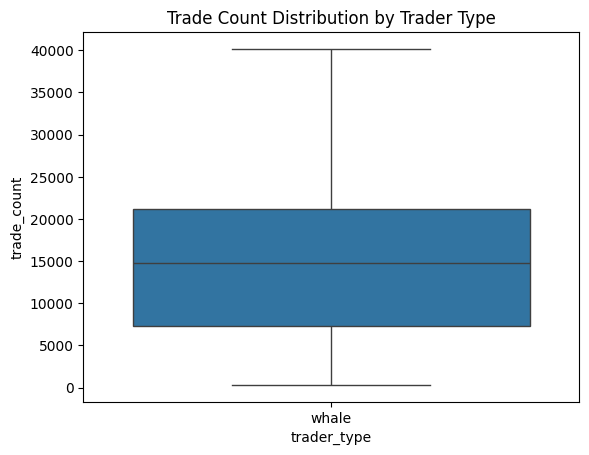

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

if not os.path.exists('outputs'):
    os.makedirs('outputs')

sns.boxplot(x='trader_type', y='trade_count', data=df)
plt.title("Trade Count Distribution by Trader Type")
plt.savefig('outputs/tradecount_by_tradertype.png')
plt.show()

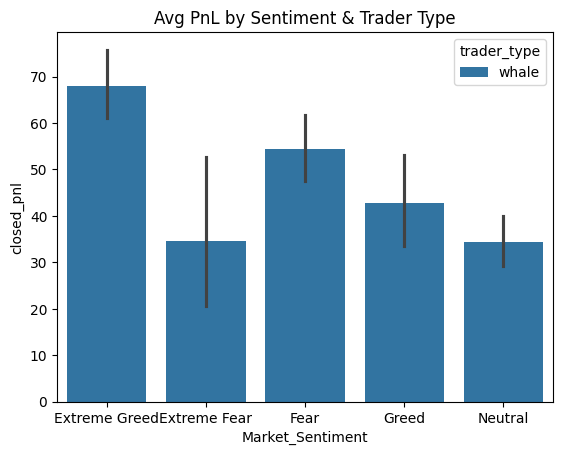

In [ ]:
sns.barplot(x='Market_Sentiment', y='closed_pnl', hue='trader_type', data=df)
plt.title("Avg PnL by Sentiment & Trader Type")
plt.savefig('outputs/avg_pnl_sentiment_tradertype.png')

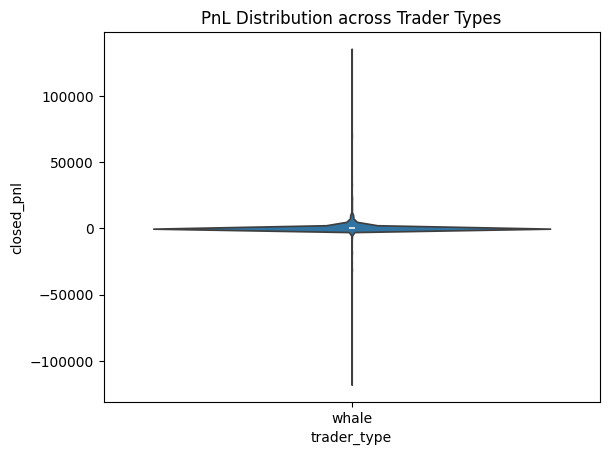

In [ ]:
sns.violinplot(x='trader_type', y='closed_pnl', data=df)
plt.title("PnL Distribution across Trader Types")
plt.savefig('outputs/pnl_violin_tradertype.png')

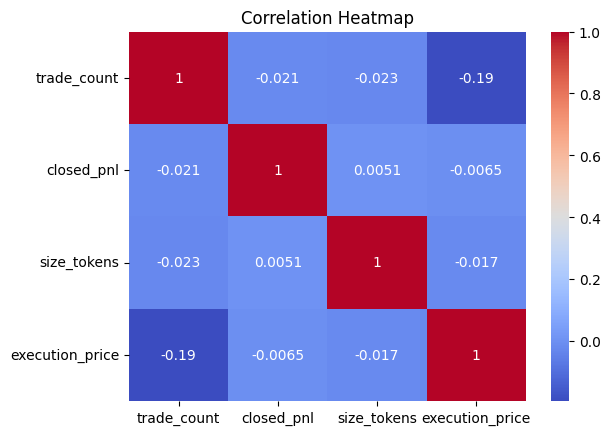

In [ ]:
sns.heatmap(df[['trade_count', 'closed_pnl', 'size_tokens', 'execution_price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig('outputs/metric_correlation.png')

In this heatmap, the correlation values are generally low, suggesting that there is a weak linear relationship between `trade_count`, `closed_pnl`, `size_tokens`, and `execution_price`.

This doesn't necessarily mean there's no relationship between these variables, but rather that a simple linear model might not fully capture their interactions. Other factors or non-linear relationships could be at play.

To further investigate, we could consider:
- **Visualizing scatter plots** for pairs of variables to see if non-linear patterns exist.
- **Exploring other correlation metrics** that can capture non-linear relationships.
- **Analyzing the data within different segments** (e.g., by `trader_type` or `Market_Sentiment`) to see if relationships are stronger in specific groups.

In [ ]:
!ls outputs/

avg_pnl_sentiment_tradertype.png  pnl_violin_tradertype.png
metric_correlation.png		  tradecount_by_tradertype.png


In [ ]:
from google.colab import files
files.download('outputs/tradecount_by_tradertype.png')
files.download('outputs/avg_pnl_sentiment_tradertype.png')
files.download('outputs/pnl_violin_tradertype.png')
files.download('outputs/metric_correlation.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_trader_agg = df.groupby('account').agg(
    avg_sentiment=('Market_Sentiment', lambda x: x.astype('category').cat.codes.mean()), # Convert sentiment to numerical and take mean
    total_trades=('account', 'size'),
    total_volume=('size_usd', 'sum'),
    avg_pnl_per_trade=('closed_pnl', 'mean')
).reset_index()

display(df_trader_agg.head())

,account,avg_sentiment,total_trades,total_volume,avg_pnl_per_trade
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2.070980,3818,61697263.97,419.127768
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2.442033,7280,12035487.66,6.577654
2,0x271b280974205ca63b716753467d5a371de622ab,2.036493,3809,33873440.42,-18.492043
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.708136,13311,6757022.10,9.951530
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2.179376,3239,10166880.20,52.071011


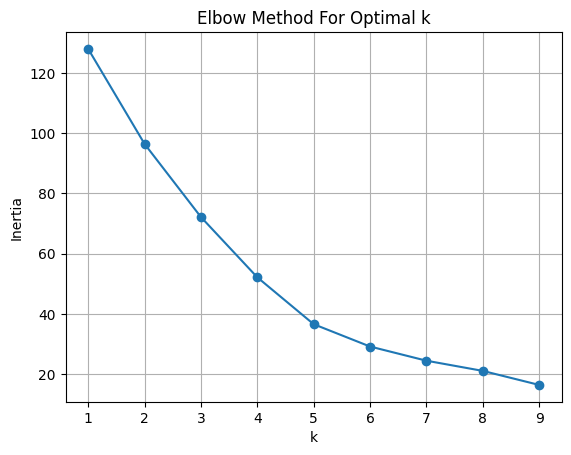

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

features = df_trader_agg[['avg_sentiment', 'total_trades', 'total_volume', 'avg_pnl_per_trade']].copy()

features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig("outputs/kmeans_elbow_method.png")
plt.show()

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_trader_agg['cluster'] = kmeans.fit_predict(scaled)

In [ ]:
cluster_profile = df_trader_agg.groupby('cluster')[['avg_sentiment', 'total_trades', 'total_volume', 'avg_pnl_per_trade']].mean()
print(cluster_profile)

         avg_sentiment  total_trades  total_volume  avg_pnl_per_trade
cluster                                                              
0             2.065983   3240.944444  1.425293e+07         145.046080
1             2.615613  15321.571429  1.036247e+08          45.676522
2             1.241636   6519.428571  2.989458e+07          27.913770


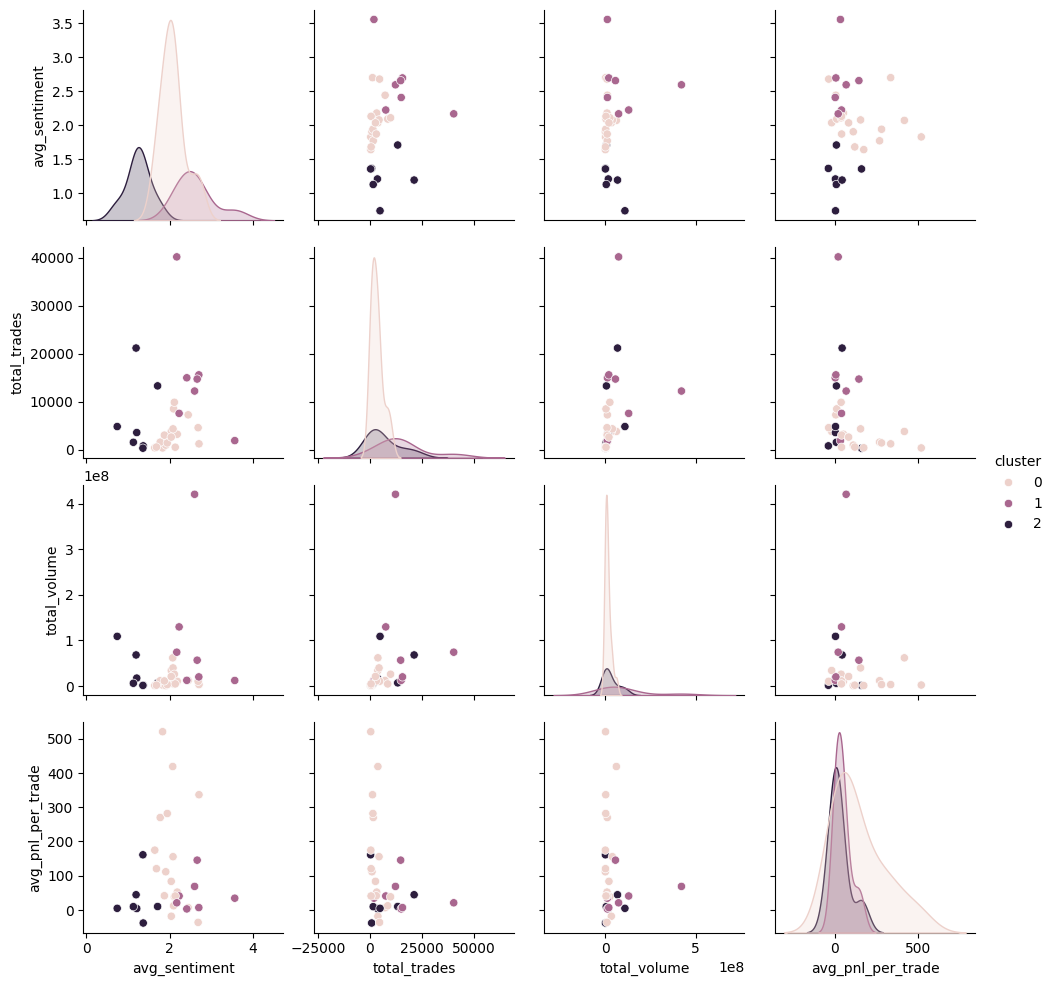

In [ ]:
import seaborn as sns

sns.pairplot(df_trader_agg, hue='cluster', diag_kind='kde')
plt.savefig("outputs/trader_clusters_pairplot.png")
plt.show()

In [ ]:
!ls outputs/

avg_pnl_sentiment_tradertype.png  pnl_violin_tradertype.png
kmeans_elbow_method.png		  tradecount_by_tradertype.png
metric_correlation.png		  trader_clusters_pairplot.png


In [24]:
from google.colab import files
files.download('outputs/kmeans_elbow_method.png')
files.download('outputs/trader_clusters_pairplot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
df_trader_agg['profitable'] = df_trader_agg['avg_pnl_per_trade'] > 0
X = df_trader_agg[['avg_sentiment', 'total_trades', 'total_volume']]
y = df_trader_agg['profitable']

In [35]:
import pandas as pd
import numpy as np

def prepare_trader_features(df):
    df = df.copy()

    df['profit_label'] = (df['closed_pnl'] > 0).astype(int)

    feature_cols = ['trade_count', 'size_usd', 'execution_price']
    df = df.dropna(subset=feature_cols + ['profit_label'])

    df['size_usd'] = np.log1p(df['size_usd'])
    df['execution_price'] = np.log1p(df['execution_price'])

    return df[feature_cols + ['profit_label']]

In [52]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def train_model_xgb(df):
    X = df.drop(columns='profit_label')
    y = df['profit_label']
    feature_names = X.columns.tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))

    return model, feature_names

In [70]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 4))
    plt.title("Feature Importance")
    plt.bar([feature_names[i] for i in indices], importances[indices], color='skyblue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('outputs/feature_importance.png')
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:36:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7520653331755237
F1 Score: 0.658938456528818
ROC-AUC: 0.726547601035054


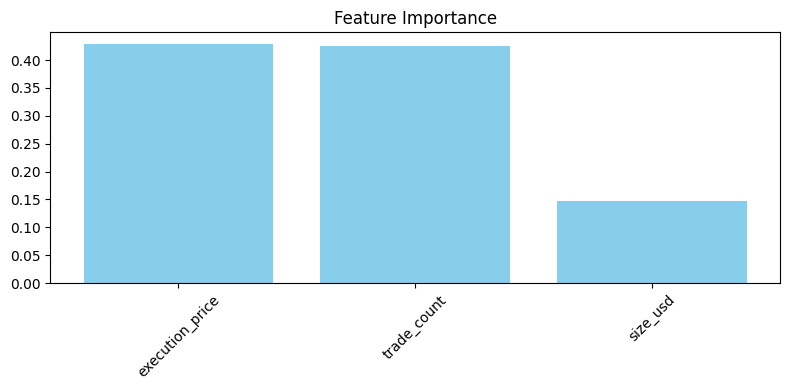

In [71]:
processed_df = prepare_trader_features(df)

model_xgb, feature_names_xgb = train_model_xgb(processed_df)

plot_feature_importance(model_xgb, feature_names_xgb)


In [63]:
def predict_trader_profitability(model, df):
    df = df.copy()

    feature_cols = ['trade_count', 'size_usd', 'execution_price']

    df['size_usd'] = np.log1p(df['size_usd'])
    df['execution_price'] = np.log1p(df['execution_price'])

    df = df.dropna(subset=feature_cols)

    df['predicted_profitability'] = model.predict(df[feature_cols])
    df['confidence_score'] = model.predict_proba(df[feature_cols])[:, 1]

    return df

In [68]:
data = {
    'trade_count': [100, 500, 50],
    'size_usd': [10000, 50000, 2000],
    'execution_price': [10, 50, 5],
    'trader_id': ['trader_a', 'trader_b', 'trader_c']
}
new_df = pd.DataFrame(data)

predicted_df = predict_trader_profitability(model, new_df)

print(predicted_df[['trader_id', 'predicted_profitability', 'confidence_score']].head())

  trader_id  predicted_profitability  confidence_score
0  trader_a                        0          0.320574
1  trader_b                        0          0.387327
2  trader_c                        1          0.577292


In [65]:
predicted_df.to_csv("trader_predictions.csv", index=False)

In [ ]:
from google.colab import files
files.download('trader_predictions.csv')
files.download('outputs/feature_importance.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>